In [2]:
import pandas as pd
import numpy as np

# Load file
df = pd.read_excel('/content/Online Retail.xlsx')

df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# Remove missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Remove canceled invoices (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Remove negative quantity
df = df[df['Quantity'] > 0]

df.shape


(397924, 8)

In [6]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [7]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [8]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])


In [9]:
rfm['RFM_Score'] = rfm['R_score'].astype(str) + \
                   rfm['F_score'].astype(str) + \
                   rfm['M_score'].astype(str)


In [10]:
def segment(row):
    if row['R_score'] == 4 and row['F_score'] == 4:
        return 'Champions'
    elif row['F_score'] >= 3:
        return 'Loyal Customers'
    elif row['R_score'] == 1:
        return 'At Risk'
    else:
        return 'Regular Customers'

rfm['Segment'] = rfm.apply(segment, axis=1)

rfm.head()


,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_Score,Segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,At Risk
12347.0,2,7,4310.00,4,4,4,444,Champions
12348.0,75,4,1797.24,2,3,4,234,Loyal Customers
12349.0,19,1,1757.55,3,1,4,314,Regular Customers
12350.0,310,1,334.40,1,1,2,112,At Risk


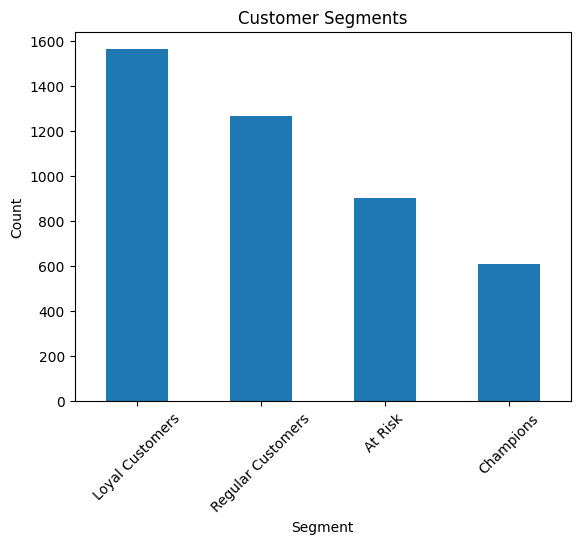

In [11]:
import matplotlib.pyplot as plt

rfm['Segment'].value_counts().plot(kind='bar')
plt.title("Customer Segments")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [12]:
rfm.to_csv('rfm_segments.csv')


# 📊 Insights from RFM Segmentation

## 1️⃣ Revenue Concentration & Customer Value Skew

Revenue distribution is highly skewed toward high-RFM segments (Champions and Loyal Customers).  
A relatively small customer base drives a disproportionate share of total revenue, indicating strong customer value concentration.

**Implication:**  
Customer retention in top-tier segments has significantly higher ROI than mass acquisition strategies.

---

## 2️⃣ Latent Revenue Opportunity in “At Risk” Segment

The "At Risk" segment includes previously high-value customers showing declining recency.  
This signals early-stage churn rather than low engagement.

**Strategic Insight:**  
Targeted reactivation campaigns for this segment can yield faster revenue recovery compared to new customer acquisition.

---

## 3️⃣ Frequency–Monetary Imbalance Indicates Upsell Potential

Certain customers exhibit high purchase frequency but moderate monetary contribution, suggesting low basket size rather than low engagement.

**Opportunity:**  
Introduce cross-selling, bundling, or pricing thresholds to optimize Average Order Value (AOV) without increasing acquisition cost.

---

## 4️⃣ Early Churn Signals in Low R & F Segments

Customers with high recency (inactive) and low frequency demonstrate churn risk behavior.

**Preventive Strategy:**  
Deploy lifecycle-based engagement interventions before complete disengagement occurs.

---

## 5️⃣ Segmentation Enables Precision Marketing Allocation

RFM segmentation transforms transactional data into actionable customer intelligence.  
It enables differentiated targeting, improves marketing efficiency, and supports long-term Customer Lifetime Value (CLV) optimization.

---

**Conclusion:**  
RFM-based segmentation provides a scalable framework for revenue optimization, churn mitigation, and strategic customer lifecycle management.
